In [3]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [4]:
import os
print(os.getcwd())

# 작업 디렉토리 변경
os.chdir('/gdrive/MyDrive/tess2')
print(os.getcwd())

/content
/gdrive/MyDrive/tess2


In [5]:
# 필요한 라이브러리 임포트
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import importlib
import sys
import os
import random
from sklearn.model_selection import KFold

# 캐싱된 모듈 삭제
if 'models' in sys.modules:
    del sys.modules['models']
if 'Segdataset' in sys.modules:
    del sys.modules['Segdataset']

# 다시 임포트
from models import CNN
from Segdataset import SegDataset,read_train_file_list
from torch.utils.data import DataLoader

In [6]:
print(CNN)

<class 'models.CNN'>


In [7]:
class Args:
    def __init__(self):
        self.data_root = '/gdrive/MyDrive/tess2/datasets/train'
        self.save_root = '/gdrive/MyDrive/tess2/checkpoints/CNN'
        self.epoch = 50
        self.lr = 3e-4
        self.batch_size = 32
        self.num_workers = 8
        self.random_seed = 1
        self.n_mfcc = 16
        self.n_splits = 5

opt = Args()


In [8]:
def main():
    print("Training by CNN")

    # 저장 디렉토리 없으면 생성
    if not os.path.exists(opt.save_root):
        os.makedirs(opt.save_root)
        print('Created directory:', opt.save_root)

    # 데이터셋 로딩
    mfcc_list, emotion_list = read_train_file_list(root=opt.data_root, n_mfcc=opt.n_mfcc)

    # KFold cross-validation
    kf = KFold(n_splits=opt.n_splits, shuffle=True, random_state=opt.random_seed)

    if torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')

    print(f"Using device: {device}")

    all_train_epoch_loss = []
    all_test_epoch_loss = []
    all_test_epoch_accuracy_emotion = []

    return kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion


In [9]:
def train_and_validate(kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion):
    for fold, (train_idx, val_idx) in enumerate(kf.split(mfcc_list)):
        print(f"Fold {fold + 1}/{opt.n_splits}")

        # 모델을 fold마다 초기화
        model = CNN().to(device)

        # 학습/검증 데이터로 쪼개기
        train_mfcc = [mfcc_list[i] for i in train_idx]
        train_emotion = [emotion_list[i] for i in train_idx]
        val_mfcc = [mfcc_list[i] for i in val_idx]
        val_emotion = [emotion_list[i] for i in val_idx]

        train_set = SegDataset(train_mfcc, train_emotion)
        val_set = SegDataset(val_mfcc, val_emotion)

        # Create dataloaders
        train_loader = DataLoader(train_set, batch_size=opt.batch_size, shuffle=True, drop_last=True, num_workers=opt.num_workers)
        val_loader = DataLoader(val_set, batch_size=opt.batch_size, shuffle=False, drop_last=True, num_workers=opt.num_workers)

        # 각 fold에 따라 pos_weight 동적으로 설정
        num_pos = sum(em == 1 for em in train_emotion)
        num_neg = sum(em == 0 for em in train_emotion)
        pos_weight = torch.tensor([num_neg / num_pos]).to(device) if num_pos > 0 else torch.tensor([1.0]).to(device)

        # loss and optimizer 선언
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
        optimizer = optim.Adam(model.parameters(), lr=opt.lr)

        # 현재 폴드 값들 저장
        train_losses = []
        val_losses = []
        val_accuracies = []

        best_val_loss = float('inf')
        best_epoch = 0

        for epo in range(opt.epoch):
            model.train()
            train_loss = 0

            for index, (mfcc, emotion) in enumerate(train_loader):
                mfcc, emotion = mfcc.to(device), emotion.to(device)
                optimizer.zero_grad()
                output_emotion = model(mfcc)

                emotion = emotion.float()
                loss = criterion(output_emotion[:, 0].squeeze(), emotion)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            # 검증
            model.eval()
            val_loss = 0
            correct_emotion = 0
            total = 0
            with torch.no_grad():
                for mfcc, emotion in val_loader:
                    mfcc, emotion = mfcc.to(device), emotion.to(device)
                    output_emotion = model(mfcc)
                    emotion = emotion.float()

                    loss = criterion(output_emotion[:, 0].squeeze(), emotion)
                    val_loss += loss.item()

                    predicted_emotion = (torch.sigmoid(output_emotion[:, 0]) > 0.56).float()
                    correct_emotion += (predicted_emotion == emotion).sum().item()
                    total += emotion.size(0)

            val_accuracy = correct_emotion / total
            print(f"Fold {fold + 1} | Epoch {epo} | Train Loss: {train_loss / len(train_loader)} | Val Loss: {val_loss / len(val_loader)} | Val Accuracy: {val_accuracy}")

            # 모델 저장
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epo
                torch.save(model.state_dict(), os.path.join(opt.save_root, f'fold_{fold + 1}_best_epoch.pth'))

            # Track the training and validation losses and accuracies for plotting later
            train_losses.append(train_loss / len(train_loader))
            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(val_accuracy)

        print(f"Fold{fold+1} best epoch : {best_epoch} ")

        all_train_epoch_loss.append(train_losses)
        all_test_epoch_loss.append(val_losses)
        all_test_epoch_accuracy_emotion.append(val_accuracies)

        plot_fold_performance(train_losses, val_losses, val_accuracies, fold)

    return all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion


In [10]:
def plot_fold_performance(train_losses, val_losses, val_accuracies, fold):
    # Fold별로 그래프를 그리기 (Colab에서 바로 확인 가능하도록)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Fold {fold + 1} Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


Training by CNN
Using device: cuda
Fold 1/5
Dataset loaded with 1792 samples.
Dataset loaded with 448 samples.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Fold 1 | Epoch 0 | Train Loss: 0.592529972749097 | Val Loss: 0.5924103387764522 | Val Accuracy: 0.43526785714285715
Fold 1 | Epoch 1 | Train Loss: 0.5866218166691917 | Val Loss: 0.5851007295506341 | Val Accuracy: 0.4642857142857143
Fold 1 | Epoch 2 | Train Loss: 0.5679895356297493 | Val Loss: 0.561826576079641 | Val Accuracy: 0.625
Fold 1 | Epoch 3 | Train Loss: 0.545177544334105 | Val Loss: 0.5487786063126155 | Val Accuracy: 0.6383928571428571
Fold 1 | Epoch 4 | Train Loss: 0.5300004035234451 | Val Loss: 0.5384985570396695 | Val Accuracy: 0.6651785714285714
Fold 1 | Epoch 5 | Train Loss: 0.5210006258317402 | Val Loss: 0.5349201858043671 | Val Accuracy: 0.6741071428571429
Fold 1 | Epoch 6 | Train Loss: 0.5179601971592221 | Val Loss: 0.5258188439267022 | Val Accuracy: 0.6941964285714286
Fold 1 | Epoch 7 | Train Loss: 0.5137110448309353 | Val Loss: 0.5476096187319074 | Val Accuracy: 0.6495535714285714
Fold 1 | Epoch 8 | Train Loss: 0.5065928559218135 | Val Loss: 0.5261482213224683 | Val 

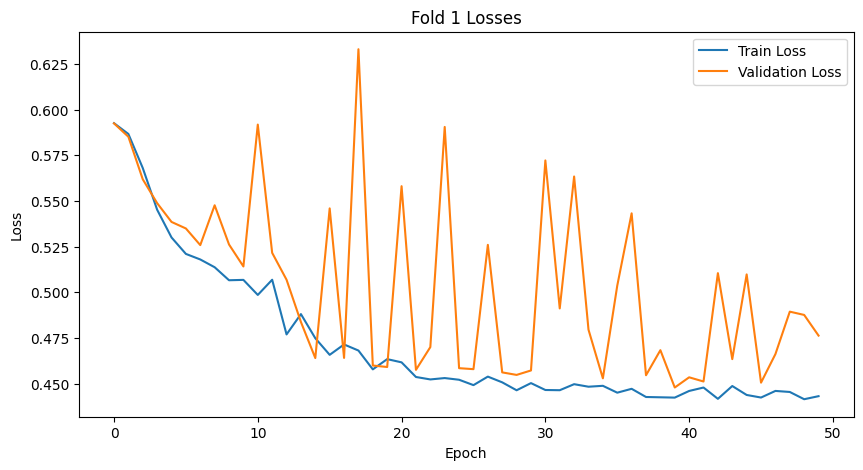

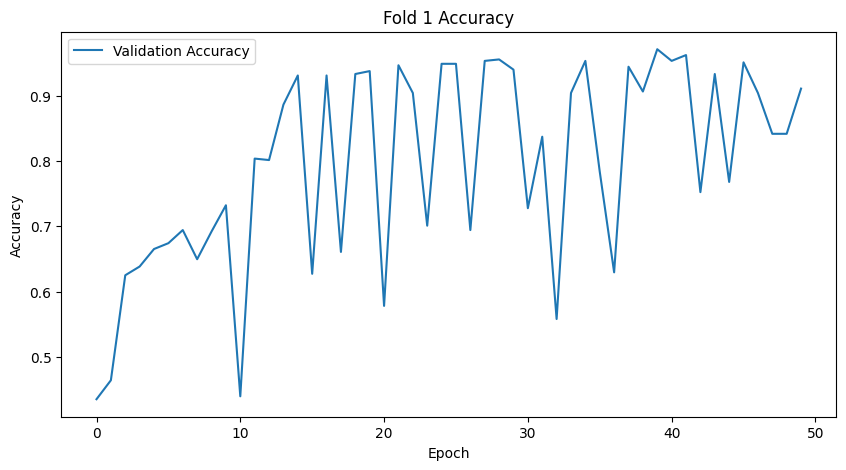

Fold 2/5
Dataset loaded with 1792 samples.
Dataset loaded with 448 samples.
Fold 2 | Epoch 0 | Train Loss: 0.6006385854312352 | Val Loss: 0.5851405369383949 | Val Accuracy: 0.5915178571428571
Fold 2 | Epoch 1 | Train Loss: 0.5832968758685249 | Val Loss: 0.5557851152760642 | Val Accuracy: 0.5892857142857143
Fold 2 | Epoch 2 | Train Loss: 0.5595059884446008 | Val Loss: 0.5300406707184655 | Val Accuracy: 0.6919642857142857
Fold 2 | Epoch 3 | Train Loss: 0.546144576477153 | Val Loss: 0.5085683699165072 | Val Accuracy: 0.8169642857142857
Fold 2 | Epoch 4 | Train Loss: 0.5234334202749389 | Val Loss: 0.48784167425973074 | Val Accuracy: 0.8727678571428571
Fold 2 | Epoch 5 | Train Loss: 0.5072994131062712 | Val Loss: 0.4773215225764683 | Val Accuracy: 0.8772321428571429
Fold 2 | Epoch 6 | Train Loss: 0.49926757706063135 | Val Loss: 0.5073106448565211 | Val Accuracy: 0.8058035714285714
Fold 2 | Epoch 7 | Train Loss: 0.4879838622042111 | Val Loss: 0.4662133753299713 | Val Accuracy: 0.901785714285

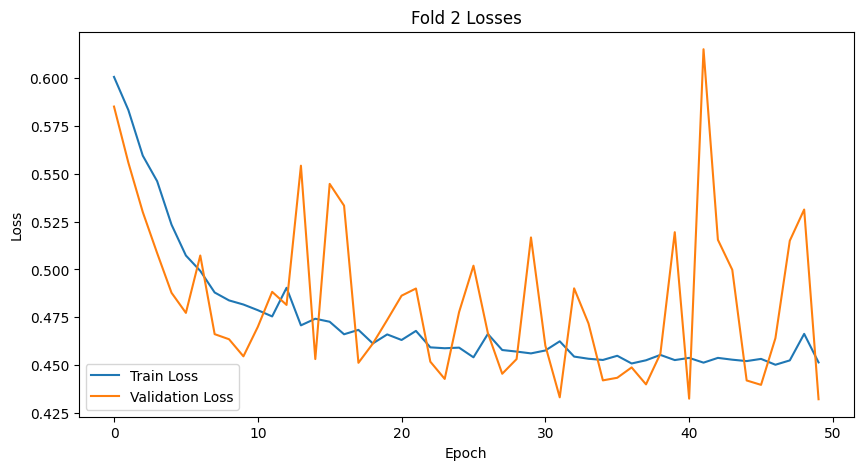

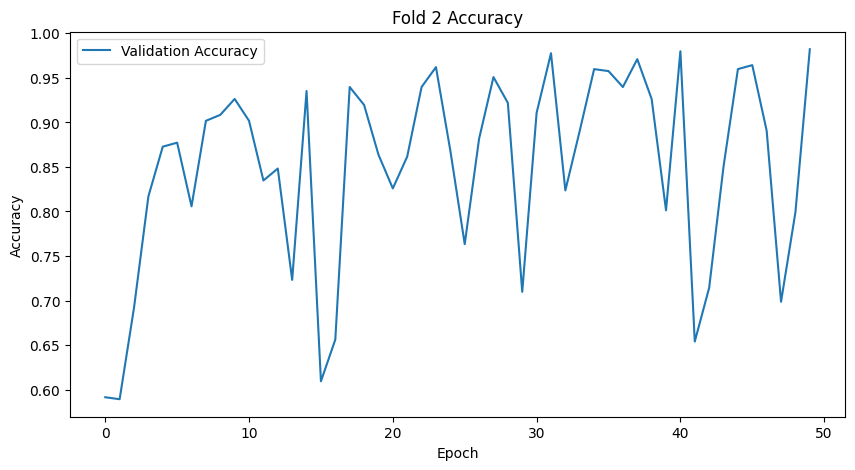

Fold 3/5
Dataset loaded with 1792 samples.
Dataset loaded with 448 samples.
Fold 3 | Epoch 0 | Train Loss: 0.5876679729138102 | Val Loss: 0.5855231008359364 | Val Accuracy: 0.453125
Fold 3 | Epoch 1 | Train Loss: 0.5735922817673001 | Val Loss: 0.5643414961440223 | Val Accuracy: 0.6026785714285714
Fold 3 | Epoch 2 | Train Loss: 0.548007396715028 | Val Loss: 0.6742980182170868 | Val Accuracy: 0.5625
Fold 3 | Epoch 3 | Train Loss: 0.5232677097831454 | Val Loss: 0.5616990923881531 | Val Accuracy: 0.578125
Fold 3 | Epoch 4 | Train Loss: 0.506332664085286 | Val Loss: 0.5337437838315964 | Val Accuracy: 0.6808035714285714
Fold 3 | Epoch 5 | Train Loss: 0.5057867941047464 | Val Loss: 0.5224146534289632 | Val Accuracy: 0.7879464285714286
Fold 3 | Epoch 6 | Train Loss: 0.49846640122788294 | Val Loss: 0.5143158159085682 | Val Accuracy: 0.7790178571428571
Fold 3 | Epoch 7 | Train Loss: 0.49000568421823637 | Val Loss: 0.5093418955802917 | Val Accuracy: 0.8392857142857143
Fold 3 | Epoch 8 | Train Los

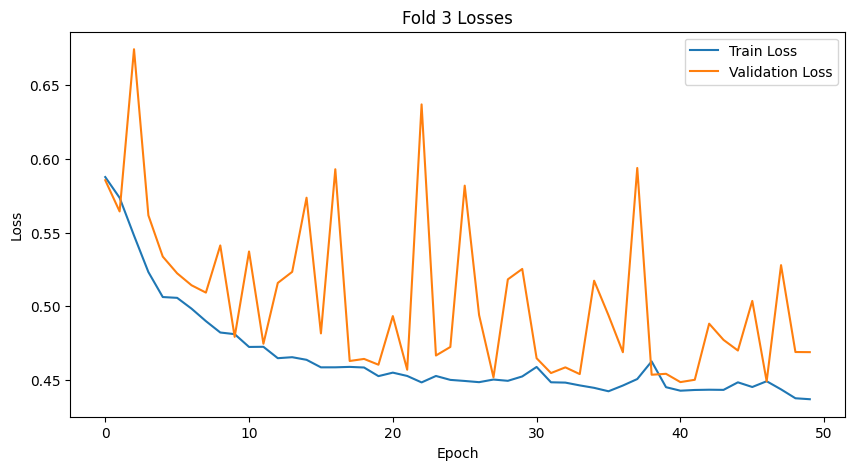

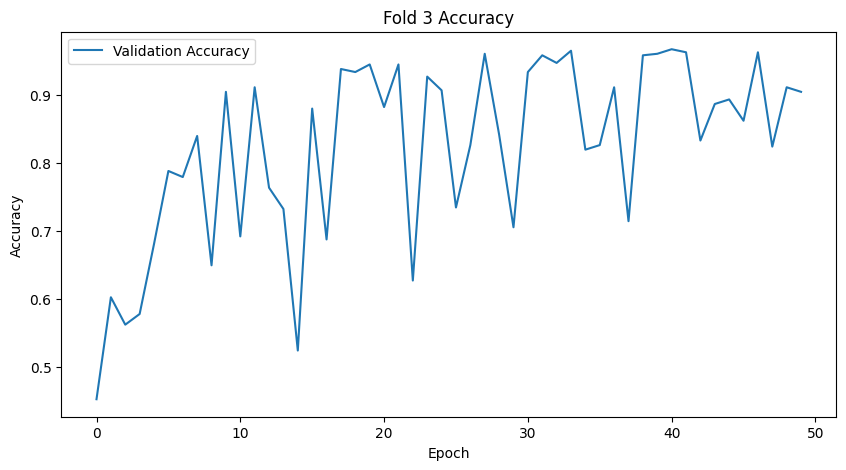

Fold 4/5
Dataset loaded with 1792 samples.
Dataset loaded with 448 samples.
Fold 4 | Epoch 0 | Train Loss: 0.6001859701105526 | Val Loss: 0.5926732463496072 | Val Accuracy: 0.40848214285714285
Fold 4 | Epoch 1 | Train Loss: 0.5832205446703094 | Val Loss: 0.5691967904567719 | Val Accuracy: 0.5424107142857143
Fold 4 | Epoch 2 | Train Loss: 0.5575868992933205 | Val Loss: 0.5476387526307788 | Val Accuracy: 0.640625
Fold 4 | Epoch 3 | Train Loss: 0.5495391163442817 | Val Loss: 0.5467319233076913 | Val Accuracy: 0.6138392857142857
Fold 4 | Epoch 4 | Train Loss: 0.5431865224880832 | Val Loss: 0.5458023175597191 | Val Accuracy: 0.65625
Fold 4 | Epoch 5 | Train Loss: 0.5335780499236924 | Val Loss: 0.558340280183724 | Val Accuracy: 0.6450892857142857
Fold 4 | Epoch 6 | Train Loss: 0.5289385324077946 | Val Loss: 0.5414459013513157 | Val Accuracy: 0.734375
Fold 4 | Epoch 7 | Train Loss: 0.5058516157524926 | Val Loss: 0.5045777154820306 | Val Accuracy: 0.8214285714285714
Fold 4 | Epoch 8 | Train Lo

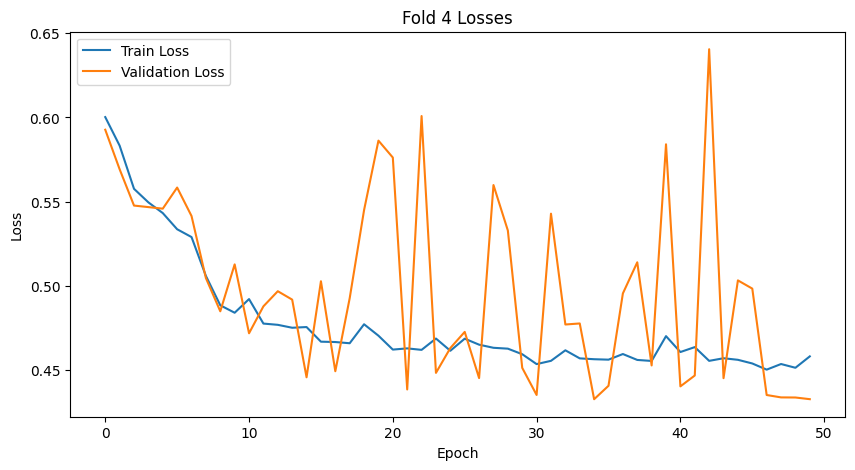

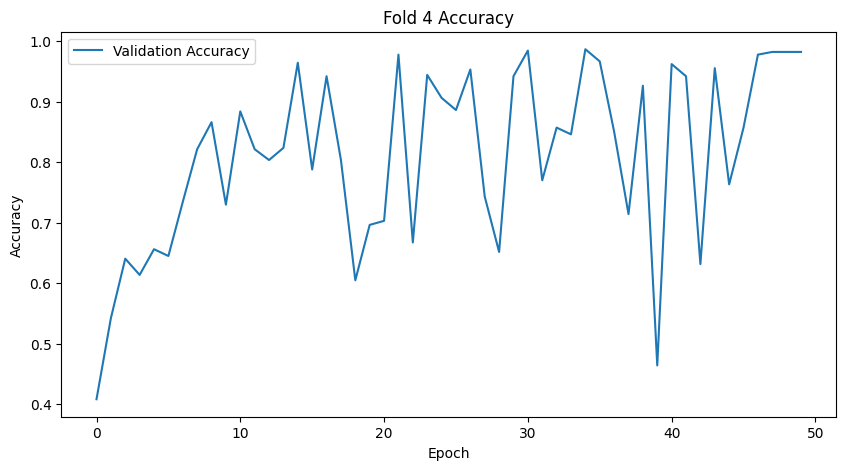

Fold 5/5
Dataset loaded with 1792 samples.
Dataset loaded with 448 samples.
Fold 5 | Epoch 0 | Train Loss: 0.5846319730792727 | Val Loss: 0.5887396995510373 | Val Accuracy: 0.47098214285714285
Fold 5 | Epoch 1 | Train Loss: 0.5683227202722004 | Val Loss: 0.558942009295736 | Val Accuracy: 0.6138392857142857
Fold 5 | Epoch 2 | Train Loss: 0.5434226383055959 | Val Loss: 0.5475168717758996 | Val Accuracy: 0.6517857142857143
Fold 5 | Epoch 3 | Train Loss: 0.5319113284349442 | Val Loss: 0.5431979277304241 | Val Accuracy: 0.6696428571428571
Fold 5 | Epoch 4 | Train Loss: 0.5234365835785866 | Val Loss: 0.6355723706739289 | Val Accuracy: 0.5915178571428571
Fold 5 | Epoch 5 | Train Loss: 0.5134300669389111 | Val Loss: 0.5575503238609859 | Val Accuracy: 0.5959821428571429
Fold 5 | Epoch 6 | Train Loss: 0.4930143281817436 | Val Loss: 0.4991500271218164 | Val Accuracy: 0.8705357142857143
Fold 5 | Epoch 7 | Train Loss: 0.4865903705358505 | Val Loss: 0.5536310970783234 | Val Accuracy: 0.6049107142857

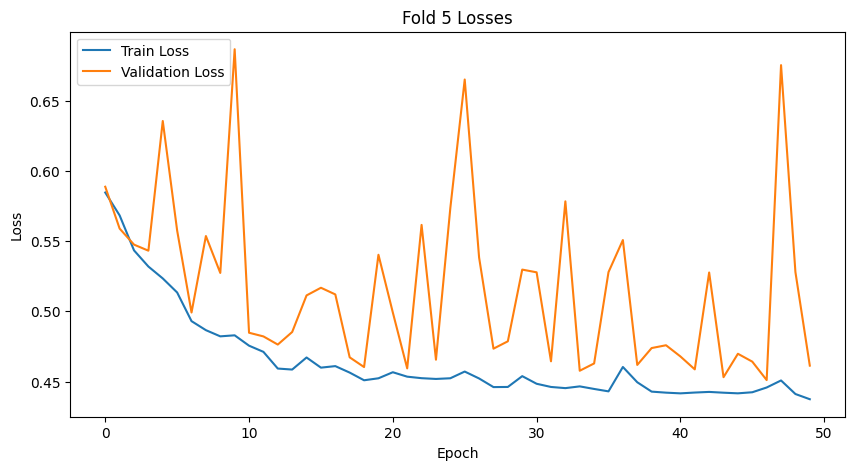

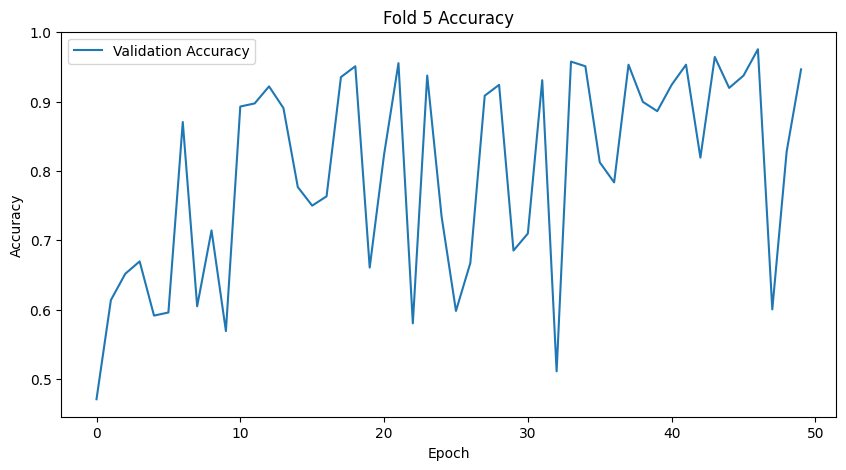

In [11]:
if __name__ == '__main__':
    kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion = main()
    train_and_validate(kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion)